In [ ]:
! wget https://raw.githubusercontent.com/irsafilo/KION_DATASET/main/data_original/items.csv

--2025-09-28 17:32:03--  https://raw.githubusercontent.com/irsafilo/KION_DATASET/main/data_original/items.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31836561 (30M) [text/plain]
Saving to: ‘items.csv’

items.csv           100%[===================>]  30.36M  --.-KB/s    in 0.1s    

2025-09-28 17:32:03 (208 MB/s) - ‘items.csv’ saved [31836561/31836561]



In [ ]:
! wget https://raw.githubusercontent.com/irsafilo/KION_DATASET/main/interactions.csv.zip
! unzip interactions.csv.zip

--2025-09-28 17:32:03--  https://raw.githubusercontent.com/irsafilo/KION_DATASET/main/interactions.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18651415 (18M) [application/zip]
Saving to: ‘interactions.csv.zip’

interactions.csv.zi 100%[===================>]  17.79M  --.-KB/s    in 0.07s   

2025-09-28 17:32:03 (246 MB/s) - ‘interactions.csv.zip’ saved [18651415/18651415]

Archive:  interactions.csv.zip
  inflating: interactions.csv        


https://github.com/irsafilo/KION_DATASET/blob/main/README.md

# ПРАКТИЧЕСКАЯ РАБОТА: КОДИРОВАНИЕ НЕЯВНЫХ И КОНТЕКСТНЫХ ПРИЗНАКОВ

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, save_npz
import seaborn as sns

interactions = pd.read_csv('interactions.csv')
items = pd.read_csv('items.csv')

print("СТРУКТУРА ДАННЫХ INTERACTIONS:")
display(interactions.head())
print("\n\n" + "="*70)
print(f" Записей: {len(interactions):,}")
print(f" Столбцы: {list(interactions.columns)}")

СТРУКТУРА ДАННЫХ INTERACTIONS:


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0




 Записей: 1,594,787
 Столбцы: ['user_id', 'item_id', 'last_watch_dt', 'total_dur', 'watched_pct']


1. Качественные данные для рекомендаций:

    - 1.6M взаимодействий с хорошей заполненностью

    - Разнообразное поведение: от кратких просмотров (10 сек) до глубоких (4+ часа)

    - Полные просмотры (100%) присутствуют - сильный сигнал интереса

2. Разнообразные неявные сигналы:

    - Продолжительность: от секунд до нескольких часов

    - Глубина просмотра: от 0% до 100% (реальные досмотры)

    - Временной охват: данные за несколько месяцев



## 1. АНАЛИЗ ДАННЫХ: НЕЯВНЫЕ СИГНАЛЫ

In [ ]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt'], errors='coerce')
interactions = interactions.dropna(subset=['last_watch_dt'])
print(f"\n СТАТИСТИКИ НЕЯВНЫХ СИГНАЛОВ:")
print(f" Продолжительность: медиана = {interactions['total_dur'].median():.0f} сек, max = {interactions['total_dur'].max():.0f} сек")
print(f" Процент просмотра: медиана = {interactions['watched_pct'].median():.1f}%")
print(f" Период данных: от {interactions['last_watch_dt'].min().date()} до {interactions['last_watch_dt'].max().date()}")


 СТАТИСТИКИ НЕЯВНЫХ СИГНАЛОВ:
 Продолжительность: медиана = 2900 сек, max = 7241091 сек
 Процент просмотра: медиана = 32.0%
 Период данных: от 2021-03-13 до 2021-08-22


1. Продолжительность просмотров
 - Медиана: 2900 сек (≈48 минут) - ОЧЕНЬ длинный контент

  - Максимум: 7 241 091 сек (≈83 дня!) - данные 4-х летней давности

2. Процент просмотра
  - Медиана: 32% - очень низкий показатель завершенности


3. Период данных
  - Всего 5 месяцев (март-август 2021)


In [ ]:
print(f"Уникальных пар user-item: {interactions[['user_id', 'item_id']].drop_duplicates().shape[0]}")
print(f"Всего записей: {len(interactions)}")

user_item_counts = interactions.groupby(['user_id', 'item_id']).size()
print(f"Макс. повторений у пары: {user_item_counts.max()}")
print(f"Распределение частот:\n{user_item_counts.value_counts().sort_index()}")

Уникальных пар user-item: 1594786
Всего записей: 1594786
Макс. повторений у пары: 1
Распределение частот:
1    1594786
Name: count, dtype: int64


In [ ]:
print("\n РАСПРЕДЕЛЕНИЕ  ДАННЫХ:")
print("total_dur статистика:")
print(interactions['total_dur'].describe())
print("\nwatched_pct статистика:")
print(interactions['watched_pct'].describe())

def check_ranges(df):
    print("\n ПРОВЕРКА ДИАПАЗОНОВ:")

    # диапазоны по длительностям
    dur_ranges = [0, 10, 60, 300, 900, 1800, 3600, float('inf')]
    for i in range(len(dur_ranges)-1):
        count = ((df['total_dur'] >= dur_ranges[i]) & (df['total_dur'] < dur_ranges[i+1])).sum()
        if count > 0:
            print(f"duration {dur_ranges[i]}-{dur_ranges[i+1]}s: {count} записей")
    print('='*70)
    # диапазоны по завершенности просмотра
    comp_ranges = [0, 1, 5, 20, 50, 80, 95, 101]
    for i in range(len(comp_ranges)-1):
        count = ((df['watched_pct'] >= comp_ranges[i]) & (df['watched_pct'] < comp_ranges[i+1])).sum()
        if count > 0:
            print(f"completion {comp_ranges[i]}-{comp_ranges[i+1]}%: {count} записей")

check_ranges(interactions)


 РАСПРЕДЕЛЕНИЕ  ДАННЫХ:
total_dur статистика:
count    1.594786e+06
mean     8.275508e+03
std      3.326120e+04
min      1.000000e+00
25%      3.710000e+02
50%      2.900000e+03
75%      7.124000e+03
max      7.241091e+06
Name: total_dur, dtype: float64

watched_pct статистика:
count    1.594519e+06
mean     4.636561e+01
std      4.191284e+01
min      0.000000e+00
25%      4.000000e+00
50%      3.200000e+01
75%      1.000000e+02
max      1.000000e+02
Name: watched_pct, dtype: float64

 ПРОВЕРКА ДИАПАЗОНОВ:
duration 0-10s: 55399 записей
duration 10-60s: 136696 записей
duration 60-300s: 180723 записей
duration 300-900s: 204326 записей
duration 900-1800s: 119228 записей
duration 1800-3600s: 151204 записей
duration 3600-infs: 747210 записей
completion 0-1%: 212234 записей
completion 1-5%: 192687 записей
completion 5-20%: 283554 записей
completion 20-50%: 202126 записей
completion 50-80%: 140748 записей
completion 80-95%: 90877 записей
completion 95-101%: 472293 записей


**Наблюдения**:
- **Медиана 2900 сек (48 мин)** и **Среднее 8275 сек (138 мин)** → сильный перекос вправо
- **Максимум 7.2 млн сек (83 дня!)** - явные выбросы
- **75% перцентиль 7124 сек (2 часа)** - большинство просмотров разумной длины

**Распределение** по диапазонам:
- **Короткие (<10 сек): 55k** - случайные клики/ошибки
- **Средние (1-30 мин): 704k** - основная масса просмотров
- **Длинные (>1 часа): 747k** - очень много длинного контента!

**Распределение** по завершенности:
- **Брошено сразу (0-1%): 212k** - явный негативный сигнал
- **Поверхностно (1-20%): 476k** - слабый интерес
- **Средне (20-80%): 343k** - умеренное вовлечение
- **Почти полностью (80-95%): 91k** - сильный интерес
- **Полностью (95-100%): 472k** - отличный сигнал!


## 2. КОДИРОВАНИЕ НЕЯВНЫХ ОТЗЫВОВ

### 2.1 Базовое кодирование продолжительности



```

def encode_duration_percentile(total_dur):
    if total_dur < 10: return 0.01
    elif total_dur < 371: return 0.1    # 25% перцентиль
    elif total_dur < 2900: return 0.3   # 50% перцентиль  
    elif total_dur < 7124: return 0.6   # 75% перцентиль
    elif total_dur < 18000: return 0.9  # ~5 часов
    else: return 1.0                    # выбросы

```





```
def encode_duration_log(total_dur):
    return np.log1p(total_dur) / np.log1p(7200)  # нормализуем к 2 часам
```





```
def encode_duration_smooth(total_dur):
    x = min(total_dur / 3600, 4.0)  # обрезаем на 4 часах
    return 1 - np.exp(-x)  # плавный рост с насыщением
```



In [ ]:
def encode_duration(total_dur):
    if total_dur < 10: return 0.01      # случайные клики
    elif total_dur < 60: return 0.1     # краткие просмотры
    elif total_dur < 300: return 0.2    # поверхностный интерес
    elif total_dur < 900: return 0.4    # средний интерес
    elif total_dur < 1800: return 0.6   # серьезный интерес
    elif total_dur < 3600: return 0.8   # глубокий интерес
    elif total_dur < 7200: return 0.95  # очень глубокий
    else: return 1.0                    # максимальное вовлечение

interactions['duration_weight'] = interactions['total_dur'].apply(encode_duration)

### 2.2 Кодирование глубины просмотра



```
def encode_completion_percentile(watched_pct):
    if watched_pct < 4: return 0.05    # 25% перцентиль
    elif watched_pct < 32: return 0.3  # 50% перцентиль
    elif watched_pct < 100: return 0.7 # 75% перцентиль
    else: return 1.0
```





```
def encode_completion_exp(watched_pct):
    if watched_pct < 20: return watched_pct/200        # 0-0.1
    else: return 0.1 + 0.9 * (1 - np.exp(-(watched_pct-20)/50))
```



In [ ]:
def encode_completion(watched_pct):
    if watched_pct < 1: return 0.01     # практически не смотрел
    elif watched_pct < 5: return 0.05   # минимальный просмотр
    elif watched_pct < 20: return 0.2   # небольшой интерес
    elif watched_pct < 50: return 0.4   # средний интерес
    elif watched_pct < 80: return 0.7   # сильный интерес
    elif watched_pct < 95: return 0.9   # почти досмотрел
    else: return 1.0                    # полностью досмотрел

interactions['completion_weight'] = interactions['watched_pct'].apply(encode_completion)

### 2.3 Временное кодирование (экспоненциальное затухание)

In [ ]:
def use_relative_time(df):
    """Использует относительное время внутри датасета"""
    # самый последний просмотр в данных = "сейчас"
    latest_date = df['last_watch_dt'].max()

    #  дни относительно самого последнего просмотра в данных
    df['days_since_watch_relative'] = (latest_date - df['last_watch_dt']).dt.days

    # вес относительно самого последнего просмотра
    df['time_decay_weight'] = np.exp(-np.log(2) * df['days_since_watch_relative'] / 30)

    print(f"Относительное время: самый последний просмотр {latest_date.date()}")
    print(f"   Диапазон дней назад: {df['days_since_watch_relative'].min()} - {df['days_since_watch_relative'].max()}")

    return df

interactions = use_relative_time(interactions)

Относительное время: самый последний просмотр 2021-08-22
   Диапазон дней назад: 0 - 162


### 2.4 Частотное кодирование

In [ ]:
watch_count = interactions.groupby(['user_id', 'item_id']).size()
interactions['frequency_weight'] = interactions.set_index(['user_id', 'item_id']).index.map(watch_count).fillna(1)
interactions['frequency_weight'] = np.log1p(interactions['frequency_weight'])  # логарифмирование

In [ ]:
print(f" Duration weight: {interactions['duration_weight'].min():.1f} - {interactions['duration_weight'].max():.1f}")
print(f" Duration weight: {interactions['duration_weight'].mean():.3f} ± {interactions['duration_weight'].std():.3f}, median: {interactions['duration_weight'].median():.3f}")
print('='*70)
print(f" Completion weight: {interactions['completion_weight'].min():.1f} - {interactions['completion_weight'].max():.1f}")
print(f" Completion weight: {interactions['completion_weight'].mean():.3f} ± {interactions['completion_weight'].std():.3f}, median: {interactions['completion_weight'].median():.3f}")
print('='*70)
print(f" Time decay weight: {interactions['time_decay_weight'].min():.3f} - {interactions['time_decay_weight'].max():.3f}")
print(f" Time decay weight: {interactions['time_decay_weight'].mean():.3f} ± {interactions['time_decay_weight'].std():.3f}, median: {interactions['time_decay_weight'].median():.3f}")
print('='*70)
print(f" Frequency weight: {interactions['frequency_weight'].min():.3f} - {interactions['frequency_weight'].max():.3f}")
print(f" Frequency weight: {interactions['frequency_weight'].mean():.3f} ± {interactions['frequency_weight'].std():.3f}, median: {interactions['frequency_weight'].median():.3f}")

 Duration weight: 0.0 - 1.0
 Duration weight: 0.661 ± 0.351, median: 0.800
 Completion weight: 0.0 - 1.0
 Completion weight: 0.503 ± 0.401, median: 0.400
 Time decay weight: 0.024 - 1.000
 Time decay weight: 0.373 ± 0.282, median: 0.294
 Frequency weight: 0.693 - 0.693
 Frequency weight: 0.693 ± 0.000, median: 0.693


1. Duration Weight (Вес продолжительности)

 Среднее: 0.661 ± 0.351,

 Медиана: 0.800

    -  Пользователи в основном смотрят довольно длинные видео (медиана 0.8 близка к максимуму)
    - Медиана выше среднего означает, что есть некоторое количество очень коротких просмотров, которые снижают среднее значение

2. Completion Weight (Вес завершенности)

 Среднее: 0.503 ± 0.401,

 Медиана: 0.400

    - В среднем пользователи досматривают видео примерно наполовину
    - Медиана ниже среднего указывает на то, что есть много недосмотренных видео, но также есть значительное количество полностью просмотренных контента

3. Time Decay Weight (Временной вес)

Среднее: 0.373 ± 0.282,

Медиана: 0.294

    - Большинство просмотров были достаточно давно (значения далеки от 1.0)
    - Сильный перекос в сторону старых взаимодействий


## 3. ВИЗУАЛИЗАЦИЯ НЕЯВНЫХ ПРИЗНАКОВ

### 3.1 Распределение исходных признаков

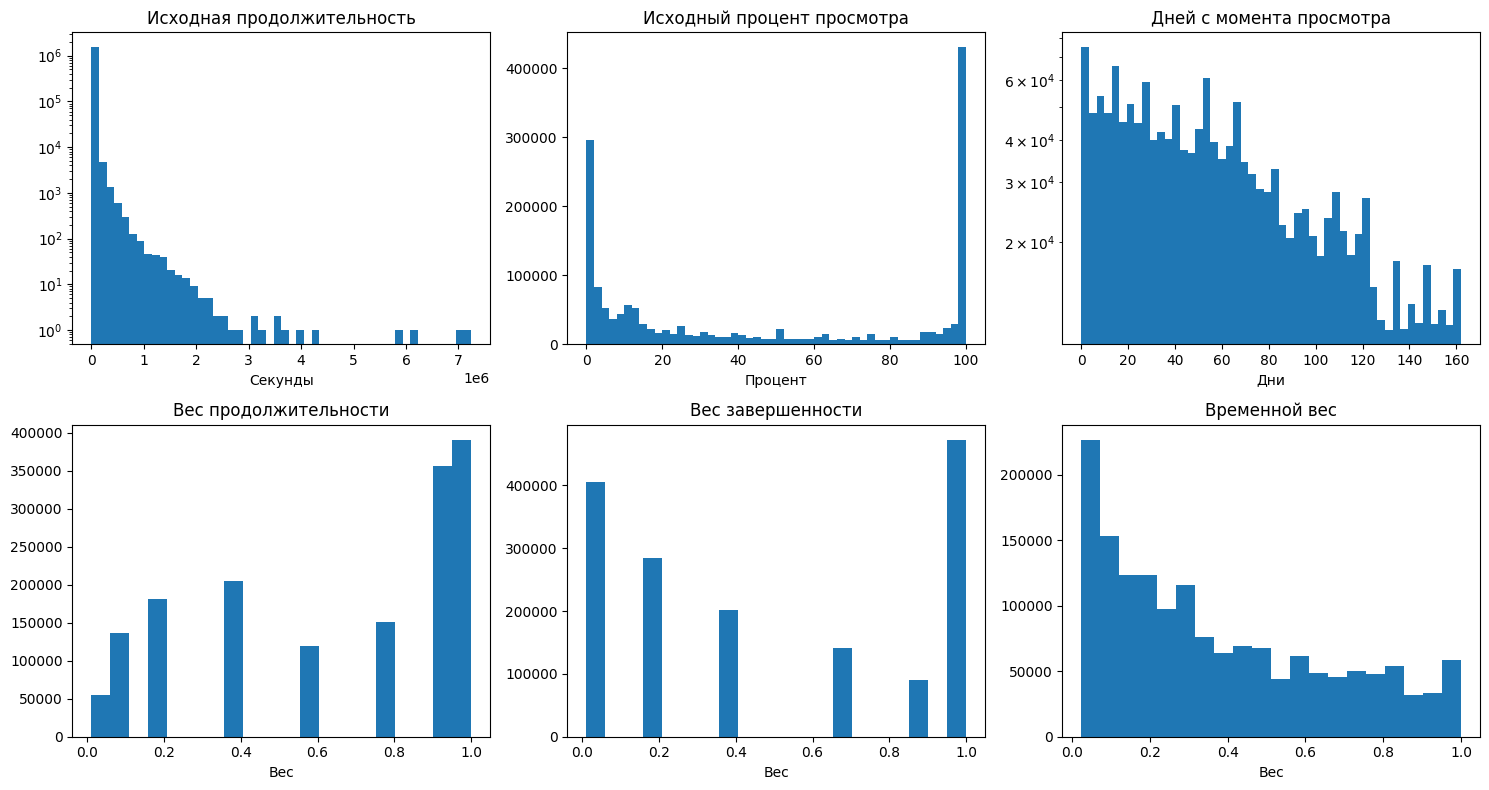

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 3.1 распределение исходных признаков
axes[0,0].hist(interactions['total_dur'], bins=50, log=True)
axes[0,0].set_title('Исходная продолжительность')
axes[0,0].set_xlabel('Секунды')

axes[0,1].hist(interactions['watched_pct'], bins=50)
axes[0,1].set_title('Исходный процент просмотра')
axes[0,1].set_xlabel('Процент')

axes[0,2].hist(interactions['days_since_watch_relative'], bins=50, log=True)
axes[0,2].set_title('Дней с момента просмотра')
axes[0,2].set_xlabel('Дни')

# 3.2 распределение закодированных весов
axes[1,0].hist(interactions['duration_weight'], bins=20)
axes[1,0].set_title('Вес продолжительности')
axes[1,0].set_xlabel('Вес')

axes[1,1].hist(interactions['completion_weight'], bins=20)
axes[1,1].set_title('Вес завершенности')
axes[1,1].set_xlabel('Вес')

axes[1,2].hist(interactions['time_decay_weight'], bins=20)
axes[1,2].set_title('Временной вес')
axes[1,2].set_xlabel('Вес')

plt.tight_layout()
plt.show()

1. **Вес продолжительности (исходная продолжительность → вес)**

  Гипотеза: более длинные видео требуют большего внимания пользователя, поэтому их просмотр — более сильный сигнал интереса, чем короткий клип.

  Что видим на графике: вес растёт с длительностью, но не линейно — есть насыщение.

  Если пользователь смотрит видео длительностью 10 минут или 60 минут — разница в весе есть, но между 2 часами и 5 часами разница уже мала. Это значит, что после некоторой длины видео дополнительная длительность не сильно увеличивает уверенность в интересе пользователя.


2. **Вес завершенности (процент просмотра → вес)**
  
  Гипотеза: чем больше процентов видео досмотрено, тем сильнее интерес.

  График: почти линейный рост до ~80%, затем резкий скачок к 100%.

  Просмотр до 80% — хороший сигнал, но не максимальный. Полный просмотр (100%) — более сильный сигнал.

  Резкий скачок на 100% может также бороться с шумом — когда пользователь остановился в конце из-за помех, но система считает это осознанным завершением.

3. **Временной вес (дни с момента просмотра → вес)**

  Гипотеза: свежие просмотры лучше отражают текущие интересы.

  График: экспоненциальный спад.

  В первые 7 дней вес падает сильно — интересы быстро меняются.
  После 30 дней вес небольшой, но не нулевой — сохраняется память о долгосрочных предпочтениях.
  После 100 дней влияние почти исчезает — имитация устаревания профиля интересов.


## 4. КОДИРОВАНИЕ КОНТЕКСТНЫХ ПРИЗНАКОВ

In [ ]:
# добавим контекстные данные
interactions_context = interactions.merge(
    items[['item_id', 'content_type', 'genres', 'release_year', 'age_rating']],
    on='item_id',
    how='left'
)

interactions_context = interactions_context.dropna(subset=['release_year'])
print(" ДОСТУПНЫЕ КОНТЕКСТНЫЕ ПРИЗНАКИ:")
print(f" Типы контента: {interactions_context['content_type'].nunique()} уникальных")
print(f" Годы выпуска: от {interactions_context['release_year'].min():.0f} до {interactions_context['release_year'].max():.0f}")
print(f" Возрастные рейтинги: {interactions_context['age_rating'].nunique()} уникальных")

 ДОСТУПНЫЕ КОНТЕКСТНЫЕ ПРИЗНАКИ:
 Типы контента: 2 уникальных
 Годы выпуска: от 1916 до 2021
 Возрастные рейтинги: 6 уникальных


In [ ]:
interactions_context['content_type'].value_counts()

,count
content_type,
film,1203948
series,390743


In [ ]:
interactions_context['age_rating'].value_counts()

,count
age_rating,
16.0,628613
18.0,490667
12.0,250412
6.0,144828
0.0,70555
21.0,9613


### 4.1 Кодирование типа контента

In [ ]:
content_type_weights = {
    'film': 1.0,      # базовый вес
    'series': 1.1     # сериалы имеют более высокую вовлеченность
}
interactions_context['content_type_weight'] = interactions_context['content_type'].map(content_type_weights).fillna(1.0)

### 4.2 Кодирование свежести контента

In [ ]:
current_year = interactions_context['release_year'].max()
interactions_context['content_age'] = current_year - interactions_context['release_year']
interactions_context['content_recency_weight'] = np.exp(-interactions_context['content_age'] / 20)  # полураспад 20 лет

### 4.3 Кодирование возрастного рейтинга

In [ ]:
def encode_age_rating(age_rating):
    if pd.isna(age_rating): return 1.0
    if age_rating >= 21: return 1.05    # эксклюзивный контент
    elif age_rating >= 18: return 1.04  # взрослый контент
    elif age_rating >= 16: return 1.03  # для старших подростков
    elif age_rating >= 12: return 1.02  # стандартный
    elif age_rating >= 6: return 1.01   # детский
    else: return 1.0                    # для самых маленьких

interactions_context['age_rating_weight'] = interactions_context['age_rating'].apply(encode_age_rating)

In [ ]:
print("КОНТЕКСТНЫЕ ПРИЗНАКИ ЗАКОДИРОВАНЫ:")
print(f"- Content type weights: {content_type_weights}")
print(f"- Content recency: полураспад 20 лет")
print(f"- Age rating: дифференцированные веса")

КОНТЕКСТНЫЕ ПРИЗНАКИ ЗАКОДИРОВАНЫ:
- Content type weights: {'film': 1.0, 'series': 1.1}
- Content recency: полураспад 20 лет
- Age rating: дифференцированные веса


## 5. КОМБИНАЦИЯ НЕЯВНЫХ И КОНТЕКСТНЫХ ПРИЗНАКОВ

### 5.1 Комбинирование неявных признаков



```
final = (duration*0.4 + completion*0.4 + time_decay*0.2) * content_type
```



In [ ]:
interactions_context['implicit_combined'] = (
    interactions_context['duration_weight'] *
    interactions_context['completion_weight'] *
    interactions_context['time_decay_weight']
)

### 5.2 Добавление контекстных признаков

In [ ]:
interactions_context['final_weight'] = (
    interactions_context['implicit_combined'] *
    interactions_context['content_type_weight'] *
    interactions_context['content_recency_weight'] *
    interactions_context['age_rating_weight']
)

### 5.3 Нормализация весов по пользователям

Попробуйте нормализовать по медиане

In [ ]:
user_sums_implicit = interactions_context.groupby('user_id')['implicit_combined'].transform('sum')
user_sums_full = interactions_context.groupby('user_id')['final_weight'].transform('sum')

interactions_context['implicit_normalized'] = interactions_context['implicit_combined'] / user_sums_implicit
interactions_context['full_context_normalized'] = interactions_context['final_weight'] / user_sums_full


In [ ]:
print(" ПРИЗНАКИ СКОМБИНИРОВАНЫ:")
print(f"- Только неявные: {interactions_context['implicit_normalized'].min():.6f} - {interactions_context['implicit_normalized'].max():.6f}")
print(f"- Неявные + контекст: {interactions_context['full_context_normalized'].min():.6f} - {interactions_context['full_context_normalized'].max():.6f}")


 ПРИЗНАКИ СКОМБИНИРОВАНЫ:
- Только неявные: 0.000000 - 1.000000
- Неявные + контекст: 0.000000 - 1.000000


## 6. СОЗДАНИЕ МАТРИЦ ВЗАИМОДЕЙСТВИЙ

In [ ]:
def create_interaction_matrix(weights, name, df):
    """Создает матрицу пользователь - элемент"""
    user_ids = df['user_id'].unique()
    item_ids = df['item_id'].unique()
    user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
    item_to_index = {item_id: idx for idx, item_id in enumerate(item_ids)}

    row_indices = df['user_id'].map(user_to_index)
    col_indices = df['item_id'].map(item_to_index)

    matrix = csr_matrix((weights, (row_indices, col_indices)),
                       shape=(len(user_ids), len(item_ids)))

    print(f"   Матрица '{name}': {matrix.shape[0]} пользователей - {matrix.shape[1]} элементов")
    print(f"   Ненулевых элементов: {matrix.nnz:,} ({matrix.nnz/(matrix.shape[0]*matrix.shape[1])*100:.4f}% заполненности)")

    return matrix, user_to_index, item_to_index

In [ ]:
# различные варианты матриц
matrix_implicit, user_map, item_map = create_interaction_matrix(
    interactions_context['implicit_normalized'].fillna(0),
    "Только неявные признаки",
    interactions_context
)

matrix_full_context, _, _ = create_interaction_matrix(
    interactions_context['full_context_normalized'].fillna(0),
    "Неявные + контекстные признаки",
    interactions_context
)

   Матрица 'Только неявные признаки': 567576 пользователей - 12640 элементов
   Ненулевых элементов: 1,594,691 (0.0222% заполненности)
   Матрица 'Неявные + контекстные признаки': 567576 пользователей - 12640 элементов
   Ненулевых элементов: 1,594,691 (0.0222% заполненности)


## 7. СРАВНИТЕЛЬНЫЙ АНАЛИЗ

In [ ]:
methods = [
    ("Только неявные", matrix_implicit),
    ("Неявные + контекст", matrix_full_context)
]
comparison_data = []
for name, matrix in methods:
    non_zero_weights = matrix.data
    comparison_data.append({
        'Метод кодирования': name,
        'Размерность': f"{matrix.shape[0]}×{matrix.shape[1]}",
        'Ненулевых': f"{matrix.nnz:,}",
        'Заполненность': f"{matrix.nnz/(matrix.shape[0]*matrix.shape[1])*100:.4f}%",
        'Мин. вес': f"{non_zero_weights.min():.6f}",
        'Макс. вес': f"{non_zero_weights.max():.6f}",
        'Мед. вес': f"{np.median(non_zero_weights):.6f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("СРАВНЕНИЕ МЕТОДОВ КОДИРОВАНИЯ:")
display(comparison_df)

СРАВНЕНИЕ МЕТОДОВ КОДИРОВАНИЯ:


,Метод кодирования,Размерность,Ненулевых,Заполненность,Мин. вес,Макс. вес,Мед. вес
0,Только неявные,567576×12640,"1,594,691",0.0222%,0.000000,1.000000,0.173686
1,Неявные + контекст,567576×12640,"1,594,691",0.0222%,0.000000,1.000000,0.169859


### 7.1 ПОДРОБНЫЙ ПРОСМОТР ПОЛУЧЕННЫХ ВЕСОВ

In [ ]:
# названия и жанры из items
items_titles = items[['item_id', 'title', 'genres', 'content_type', 'release_year']].copy()

def format_genres(genres_str):
    """Форматируем жанры для читаемого вывода"""
    if pd.isna(genres_str):
        return "не указаны"
    try:
        if genres_str.startswith('['):
            genres_list = eval(genres_str)
            return ', '.join(genres_list[:3]) + ('...' if len(genres_list) > 3 else '')
        else:
            return str(genres_str)[:50] + ('...' if len(str(genres_str)) > 50 else '')
    except:
        return str(genres_str)[:50] + ('...' if len(str(genres_str)) > 50 else '')

items_titles['genres_formatted'] = items_titles['genres'].apply(format_genres)
items_titles['title_short'] = items_titles['title'].str[:40] + ('...' if items_titles['title'].str.len().max() > 40 else '')

interactions_titles = interactions_context.merge(
    items_titles[['item_id', 'title_short', 'genres_formatted']],
    on='item_id',
    how='left'
)

# несколько примеров для детального анализа
sample_users = interactions_titles['user_id'].unique()[:3]
detailed_examples = []

for user_id in sample_users:
    user_interactions = interactions_titles[interactions_titles['user_id'] == user_id].head(2)
    for _, row in user_interactions.iterrows():
        detailed_examples.append({
            'user_id': user_id,
            'item_id': row['item_id'],
            'title': row['title_short'] if pd.notna(row['title_short']) else f"Фильм {row['item_id']}",
            'genres': row['genres_formatted'],
            'content_type': row['content_type'],
            'total_dur_min': row['total_dur'] / 60,  # в минутах для удобства
            'watched_pct': row['watched_pct'],
            'days_ago': row['days_since_watch_relative'],
            'release_year': row['release_year'],
            'age_rating': row['age_rating'],
            # неявные веса
            'duration_weight': row['duration_weight'],
            'completion_weight': row['completion_weight'],
            'time_decay_weight': row['time_decay_weight'],
            'frequency_weight': row['frequency_weight'],
            'implicit_combined': row['implicit_combined'],
            # контекстные веса
            'content_type_weight': row['content_type_weight'],
            'content_recency_weight': row['content_recency_weight'],
            'age_rating_weight': row['age_rating_weight'],
            # итоговые веса
            'final_weight': row['final_weight'],
            'implicit_normalized': row['implicit_normalized'],
            'full_context_normalized': row['full_context_normalized']
        })


for idx, example in enumerate(detailed_examples):
    print(f"\n ПРИМЕР {idx+1}: User {example['user_id']} → '{example['title']}'")
    print("-" * 100)

    print(" ИСХОДНЫЕ ДАННЫЕ:")
    print(f"   - Название: {example['title']}")
    print(f"   - Жанры: {example['genres']}")
    print(f"   - Тип: {example['content_type']}, Год: {example['release_year']:.0f}, Рейтинг: {example['age_rating']:.0f}+")
    print(f"   - Просмотр: {example['total_dur_min']:.1f} мин ({example['watched_pct']:.1f}%), {example['days_ago']} дней назад")

    print("\n НЕЯВНЫЕ ВЕСА:")
    duration_desc = "глубокий интерес" if example['duration_weight'] > 0.7 else "серьезный интерес" if example['duration_weight'] > 0.3 else "поверхностный интерес"
    completion_desc = "досмотрел" if example['completion_weight'] > 0.8 else "посмотрел много" if example['completion_weight'] > 0.6 else "посмотрел немного"
    time_desc = "недавно" if example['time_decay_weight'] > 0.8 else "давно" if example['time_decay_weight'] < 0.3 else "в среднем"

    print(f"   - Продолжительность: {example['duration_weight']:.3f} ({duration_desc})")
    print(f"   - Завершенность: {example['completion_weight']:.3f} ({completion_desc})")
    print(f"   - Временной вес: {example['time_decay_weight']:.3f} ({time_desc})")
    print(f"   - Частотный вес: {example['frequency_weight']:.3f}")
    print(f"   - КОМБИНИРОВАННЫЙ неявный: {example['implicit_combined']:.6f}")

    print("\n КОНТЕКСТНЫЕ ВЕСА:")
    content_desc = "сериал (высокий вес)" if example['content_type_weight'] > 1.2 else "фильм (стандартный вес)"
    recency_desc = "новинка" if example['content_recency_weight'] > 0.8 else "классика" if example['content_recency_weight'] < 0.3 else "средней свежести"
    age_desc = "взрослый контент" if example['age_rating_weight'] > 1.1 else "для всех возрастов"

    print(f"   - Тип контента: {example['content_type_weight']:.3f} ({content_desc})")
    print(f"   - Свежесть контента: {example['content_recency_weight']:.3f} ({recency_desc})")
    print(f"   - Возрастной рейтинг: {example['age_rating_weight']:.3f} ({age_desc})")

    print("\n- ИТОГОВЫЕ ВЕСА:")
    enhancement = example['full_context_normalized'] / example['implicit_normalized']
    enhancement_desc = "значительное усиление" if enhancement > 1.5 else "умеренное усиление" if enhancement > 1.1 else "незначительное изменение"

    print(f"   - НОРМАЛИЗОВАННЫЙ (только неявные): {example['implicit_normalized']:.6f}")
    print(f"   - НОРМАЛИЗОВАННЫЙ (с контекстом): {example['full_context_normalized']:.6f}")
    print(f"   - УСИЛЕНИЕ от контекста: ×{enhancement:.2f} ({enhancement_desc})")



 ПРИМЕР 1: User 176549 → 'Холодное сердце...'
----------------------------------------------------------------------------------------------------
 ИСХОДНЫЕ ДАННЫЕ:
   - Название: Холодное сердце...
   - Жанры: фэнтези, мультфильм, музыкальные
   - Тип: film, Год: 2013, Рейтинг: 0+
   - Просмотр: 70.8 мин (72.0%), 103 дней назад

 НЕЯВНЫЕ ВЕСА:
   - Продолжительность: 0.950 (глубокий интерес)
   - Завершенность: 0.700 (посмотрел много)
   - Временной вес: 0.093 (давно)
   - Частотный вес: 0.693
   - КОМБИНИРОВАННЫЙ неявный: 0.061558

 КОНТЕКСТНЫЕ ВЕСА:
   - Тип контента: 1.000 (фильм (стандартный вес))
   - Свежесть контента: 0.670 (средней свежести)
   - Возрастной рейтинг: 1.000 (для всех возрастов)

- ИТОГОВЫЕ ВЕСА:
   - НОРМАЛИЗОВАННЫЙ (только неявные): 0.029914
   - НОРМАЛИЗОВАННЫЙ (с контекстом): 0.028213
   - УСИЛЕНИЕ от контекста: ×0.94 (незначительное изменение)

 ПРИМЕР 2: User 176549 → 'Безбашенная пуля...'
-------------------------------------------------------------------

### 7.2 СТАТИСТИКИ ПО ВЕСАМ

In [ ]:
weights_stats = pd.DataFrame({
    'Тип веса': [
        'Продолжительность', 'Завершенность', 'Временной', 'Частотный',
        'Тип контента', 'Свежесть контента', 'Возрастной рейтинг',
        'Комбинированный неявный', 'Полный с контекстом',
        'Нормализованный неявный', 'Нормализованный с контекстом'
    ],
    'Мин. значение': [
        interactions_context['duration_weight'].min(),
        interactions_context['completion_weight'].min(),
        interactions_context['time_decay_weight'].min(),
        interactions_context['frequency_weight'].min(),
        interactions_context['content_type_weight'].min(),
        interactions_context['content_recency_weight'].min(),
        interactions_context['age_rating_weight'].min(),
        interactions_context['implicit_combined'].min(),
        interactions_context['final_weight'].min(),
        interactions_context['implicit_normalized'].min(),
        interactions_context['full_context_normalized'].min()
    ],
    'Макс. значение': [
        interactions_context['duration_weight'].max(),
        interactions_context['completion_weight'].max(),
        interactions_context['time_decay_weight'].max(),
        interactions_context['frequency_weight'].max(),
        interactions_context['content_type_weight'].max(),
        interactions_context['content_recency_weight'].max(),
        interactions_context['age_rating_weight'].max(),
        interactions_context['implicit_combined'].max(),
        interactions_context['final_weight'].max(),
        interactions_context['implicit_normalized'].max(),
        interactions_context['full_context_normalized'].max()
    ],
    'Медиана': [
        interactions_context['duration_weight'].median(),
        interactions_context['completion_weight'].median(),
        interactions_context['time_decay_weight'].median(),
        interactions_context['frequency_weight'].median(),
        interactions_context['content_type_weight'].median(),
        interactions_context['content_recency_weight'].median(),
        interactions_context['age_rating_weight'].median(),
        interactions_context['implicit_combined'].median(),
        interactions_context['final_weight'].median(),
        interactions_context['implicit_normalized'].median(),
        interactions_context['full_context_normalized'].median()
    ]
})

print("СТАТИСТИКИ ВЕСОВ ПО ВСЕМУ ДАТАСЕТУ:")
display(weights_stats.round(4))

СТАТИСТИКИ ВЕСОВ ПО ВСЕМУ ДАТАСЕТУ:


,Тип веса,Мин. значение,Макс. значение,Медиана
0,Продолжительность,0.0100,1.0000,0.8000
1,Завершенность,0.0100,1.0000,0.4000
2,Временной,0.0237,1.0000,0.2939
3,Частотный,0.6931,0.6931,0.6931
4,Тип контента,1.0000,1.1000,1.0000
5,Свежесть контента,0.0052,1.0000,0.8607
6,Возрастной рейтинг,1.0000,1.0500,1.0300
7,Комбинированный неявный,0.0000,1.0000,0.0650
8,Полный с контекстом,0.0000,1.1440,0.0515
9,Нормализованный неявный,0.0000,1.0000,0.1737


### 7.3 ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ВЕСОВ

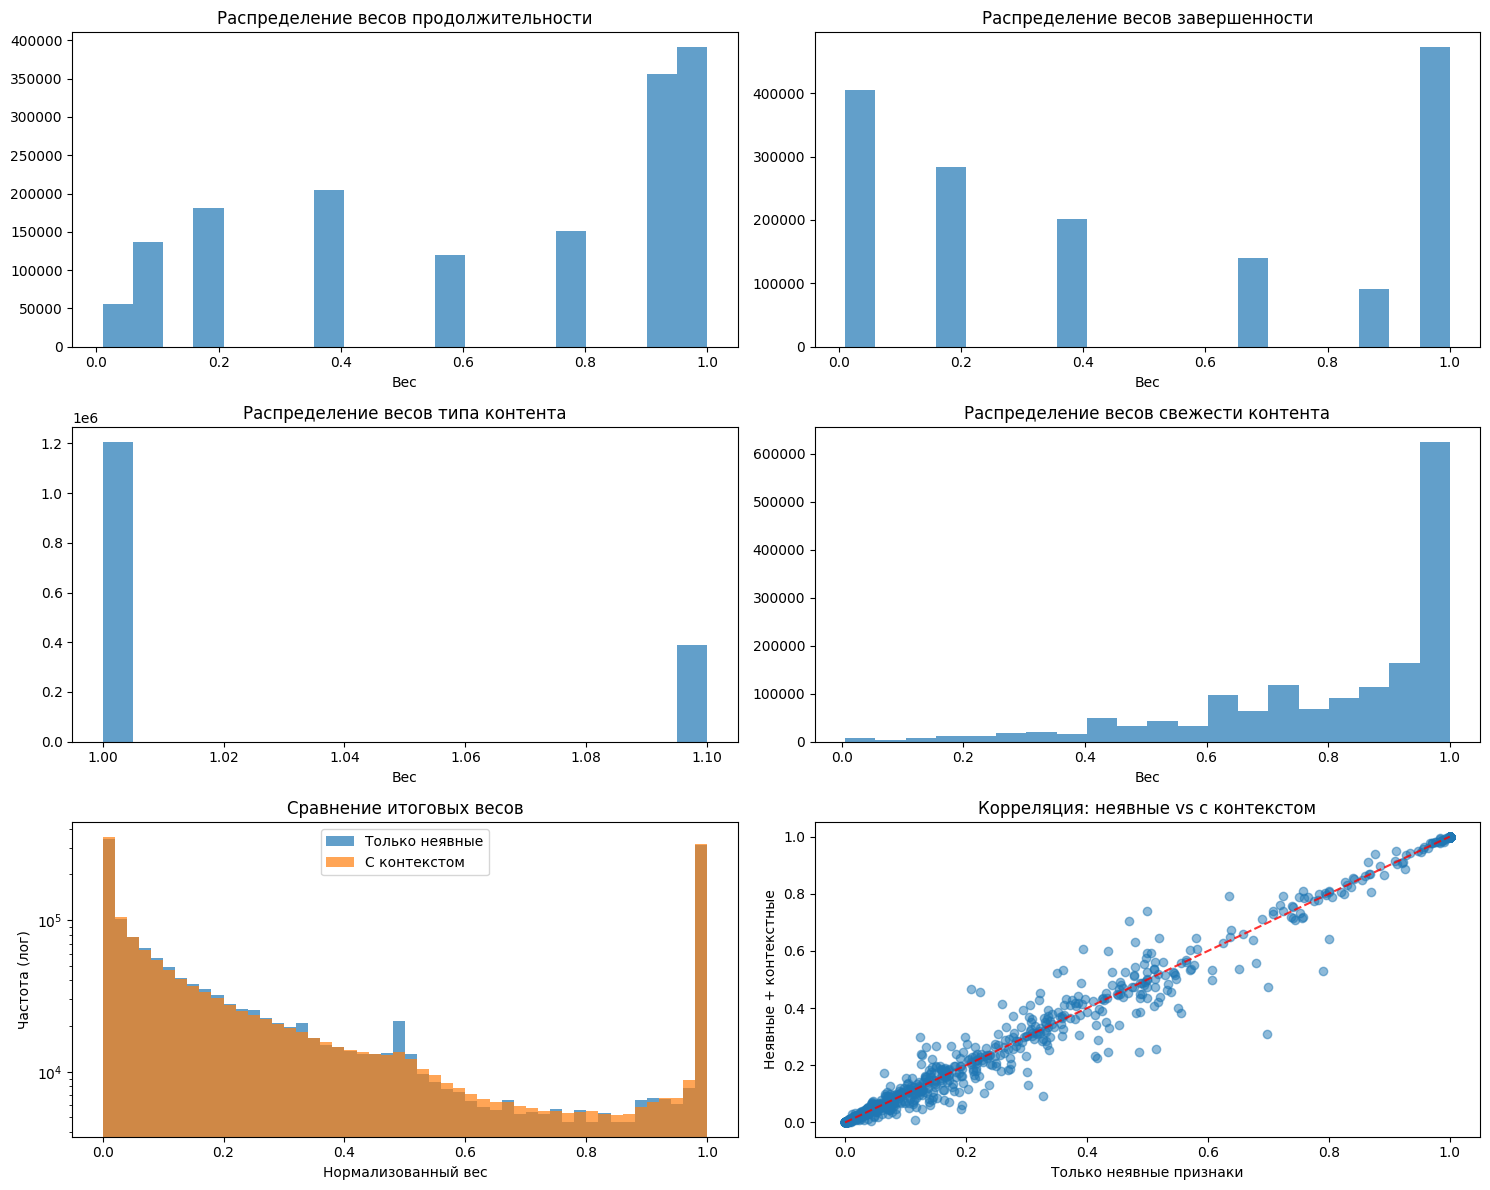

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# базовые неявные веса
axes[0,0].hist(interactions_context['duration_weight'], bins=20, alpha=0.7)
axes[0,0].set_title('Распределение весов продолжительности')
axes[0,0].set_xlabel('Вес')

axes[0,1].hist(interactions_context['completion_weight'], bins=20, alpha=0.7)
axes[0,1].set_title('Распределение весов завершенности')
axes[0,1].set_xlabel('Вес')

# контекстные веса
axes[1,0].hist(interactions_context['content_type_weight'], bins=20, alpha=0.7)
axes[1,0].set_title('Распределение весов типа контента')
axes[1,0].set_xlabel('Вес')

axes[1,1].hist(interactions_context['content_recency_weight'], bins=20, alpha=0.7)
axes[1,1].set_title('Распределение весов свежести контента')
axes[1,1].set_xlabel('Вес')

# итоговые веса
axes[2,0].hist(interactions_context['implicit_normalized'], bins=50, alpha=0.7, label='Только неявные', log=True)
axes[2,0].hist(interactions_context['full_context_normalized'], bins=50, alpha=0.7, label='С контекстом', log=True)
axes[2,0].set_title('Сравнение итоговых весов')
axes[2,0].set_xlabel('Нормализованный вес')
axes[2,0].set_ylabel('Частота (лог)')
axes[2,0].legend()

# корреляция между методами
sample_weights = interactions_context.sample(1000, random_state=42)
axes[2,1].scatter(sample_weights['implicit_normalized'], sample_weights['full_context_normalized'], alpha=0.5)
max_val = max(sample_weights['implicit_normalized'].max(), sample_weights['full_context_normalized'].max())
axes[2,1].plot([0, max_val], [0, max_val], 'r--', alpha=0.8)
axes[2,1].set_title('Корреляция: неявные vs с контекстом')
axes[2,1].set_xlabel('Только неявные признаки')
axes[2,1].set_ylabel('Неявные + контекстные')

plt.tight_layout()
plt.show()

### 7.4 АНАЛИЗ ВЛИЯНИЯ КОНТЕКСТА НА РАНЖИРОВАНИЕ

In [ ]:
# конкретный пользователь для анализа
test_user_id = interactions_titles['user_id'].iloc[0]
user_interactions = interactions_titles[interactions_titles['user_id'] == test_user_id]

# ранжируем по разным методам
user_ranked = user_interactions.nlargest(5, 'implicit_normalized')[[
    'item_id', 'title_short', 'genres_formatted', 'content_type', 'release_year', 'implicit_normalized'
]]
user_ranked_context = user_interactions.nlargest(5, 'full_context_normalized')[[
    'item_id', 'title_short', 'genres_formatted', 'content_type', 'release_year', 'full_context_normalized'
]]

print(f"\n АНАЛИЗ РАНЖИРОВАНИЯ ДЛЯ ПОЛЬЗОВАТЕЛЯ {test_user_id}:")
print("="*100)

print(" ТОП-5 ПО НЕЯВНЫМ ПРИЗНАКАМ (продолжительность + завершенность + время):")
for i, (_, row) in enumerate(user_ranked.iterrows(), 1):
    print(f"   {i}. '{row['title_short']}'")
    print(f"      Жанры: {row['genres_formatted']}, {row['content_type']} ({row['release_year']:.0f})")
    print(f"      Вес: {row['implicit_normalized']:.6f}")

print("\n ТОП-5 ПО ПРИЗНАКАМ С КОНТЕКСТОМ (+ тип контента + свежесть + возраст):")
for i, (_, row) in enumerate(user_ranked_context.iterrows(), 1):
    print(f"   {i}. '{row['title_short']}'")
    print(f"      Жанры: {row['genres_formatted']}, {row['content_type']} ({row['release_year']:.0f})")
    print(f"      Вес: {row['full_context_normalized']:.6f}")

# анализ изменений в ранжировании
print("\n ИЗМЕНЕНИЯ В РАНЖИРОВАНИИ ПРИ УЧЕТЕ КОНТЕКСТА:")
common_items = set(user_ranked['item_id']).intersection(set(user_ranked_context['item_id']))

if common_items:
    for item_id in common_items:
        item_info = items_titles[items_titles['item_id'] == item_id].iloc[0]
        rank_implicit = user_ranked[user_ranked['item_id'] == item_id].index[0] + 1
        rank_context = user_ranked_context[user_ranked_context['item_id'] == item_id].index[0] + 1
        change = rank_implicit - rank_context

        weight_implicit = user_ranked[user_ranked['item_id'] == item_id]['implicit_normalized'].iloc[0]
        weight_context = user_ranked_context[user_ranked_context['item_id'] == item_id]['full_context_normalized'].iloc[0]
        weight_change = weight_context - weight_implicit

        if change > 0:
            print(f"    '{item_info['title_short']}' поднялся с {rank_implicit} на {rank_context} место")
            print(f"      Усиление веса: {weight_change:.6f} (×{weight_context/weight_implicit:.2f})")
        elif change < 0:
            print(f"    '{item_info['title_short']}' опустился с {rank_implicit} на {rank_context} место")
            print(f"      Ослабление веса: {weight_change:.6f} (×{weight_context/weight_implicit:.2f})")
        else:
            print(f"    '{item_info['title_short']}' остался на {rank_implicit} месте")
            print(f"      Стабильный вес: {weight_context:.6f}")
else:
    print("    Ранжирование полностью изменилось! Контекст кардинально повлиял на рекомендации.")

# Анализ новых элементов в топе
new_in_top = set(user_ranked_context['item_id']) - set(user_ranked['item_id'])
if new_in_top:
    print(f"\n НОВЫЕ В ТОПЕ С КОНТЕКСТОМ:")
    for item_id in new_in_top:
        item_info = items_titles[items_titles['item_id'] == item_id].iloc[0]
        rank = user_ranked_context[user_ranked_context['item_id'] == item_id].index[0] + 1
        print(f"   {rank}. '{item_info['title_short']}' - появился в топе благодаря контексту")


 АНАЛИЗ РАНЖИРОВАНИЯ ДЛЯ ПОЛЬЗОВАТЕЛЯ 176549:
 ТОП-5 ПО НЕЯВНЫМ ПРИЗНАКАМ (продолжительность + завершенность + время):
   1. 'Моана...'
      Жанры: мультфильм, фэнтези, мюзиклы, film (2016)
      Вес: 0.156639
   2. 'Дом...'
      Жанры: фантастика, мультфильм, приключения, комедии, film (2015)
      Вес: 0.082024
   3. 'В поисках Дори...'
      Жанры: мультфильм, приключения, комедии, film (2016)
      Вес: 0.078320
   4. 'На линии огня...'
      Жанры: боевики, триллеры, film (2015)
      Вес: 0.071044
   5. 'Безбашенная пуля...'
      Жанры: боевики, триллеры, film (2019)
      Вес: 0.059054

 ТОП-5 ПО ПРИЗНАКАМ С КОНТЕКСТОМ (+ тип контента + свежесть + возраст):
   1. 'Моана...'
      Жанры: мультфильм, фэнтези, мюзиклы, film (2016)
      Вес: 0.173362
   2. 'В поисках Дори...'
      Жанры: мультфильм, приключения, комедии, film (2016)
      Вес: 0.086681
   3. 'Дом...'
      Жанры: фантастика, мультфильм, приключения, комедии, film (2015)
      Вес: 0.086353
   4. 'Безбашенная п

### 7.5 АНАЛИЗ ТИПИЧНЫХ СЦЕНАРИЕВ УСИЛЕНИЯ КОНТЕКСТОМ

In [ ]:
# примеры с максимальным усилением от контекста
interactions_titles['context_enhancement'] = interactions_titles['full_context_normalized'] / interactions_titles['implicit_normalized']
top_enhanced = interactions_titles.nlargest(3, 'context_enhancement')

print(" СЦЕНАРИИ МАКСИМАЛЬНОГО УСИЛЕНИЯ КОНТЕКСТОМ:")
for i, (_, row) in enumerate(top_enhanced.iterrows(), 1):
    enhancement = row['context_enhancement']
    print(f"\n{i}. УСИЛЕНИЕ ×{enhancement:.2f}: '{row['title_short']}'")
    print(f"   • Причина усиления: {row['content_type']} + {row['release_year']:.0f} год + {row['age_rating']:.0f}+")
    print(f"   • Неявный вес: {row['implicit_normalized']:.6f} → С контекстом: {row['full_context_normalized']:.6f}")
    print(f"   • Жанры: {row['genres_formatted']}")

# анализ каких типов контент больше всего выигрывает от контекста
enhancement_by_type = interactions_titles.groupby('content_type')['context_enhancement'].median()
print(f"\n СРЕДНЕЕ УСИЛЕНИЕ ПО ТИПАМ КОНТЕНТА:")
for content_type, enhancement in enhancement_by_type.items():
    print(f"   • {content_type}: ×{enhancement:.2f}")

 СЦЕНАРИИ МАКСИМАЛЬНОГО УСИЛЕНИЯ КОНТЕКСТОМ:

1. УСИЛЕНИЕ ×69.14: 'Девятаев - сериал...'
   • Причина усиления: series + 2021 год + 12+
   • Неявный вес: 0.000164 → С контекстом: 0.011346
   • Жанры: драмы, военные, приключения

2. УСИЛЕНИЕ ×66.97: 'ЖАRА...'
   • Причина усиления: film + 2006 год + 12+
   • Неявный вес: 0.001248 → С контекстом: 0.083603
   • Жанры: комедии

3. УСИЛЕНИЕ ×65.46: 'В центре внимания...'
   • Причина усиления: film + 2016 год + 18+
   • Неявный вес: 0.000432 → С контекстом: 0.028256
   • Жанры: драмы, биография, криминал

 СРЕДНЕЕ УСИЛЕНИЕ ПО ТИПАМ КОНТЕНТА:
   • film: ×1.00
   • series: ×1.00


## 8. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ

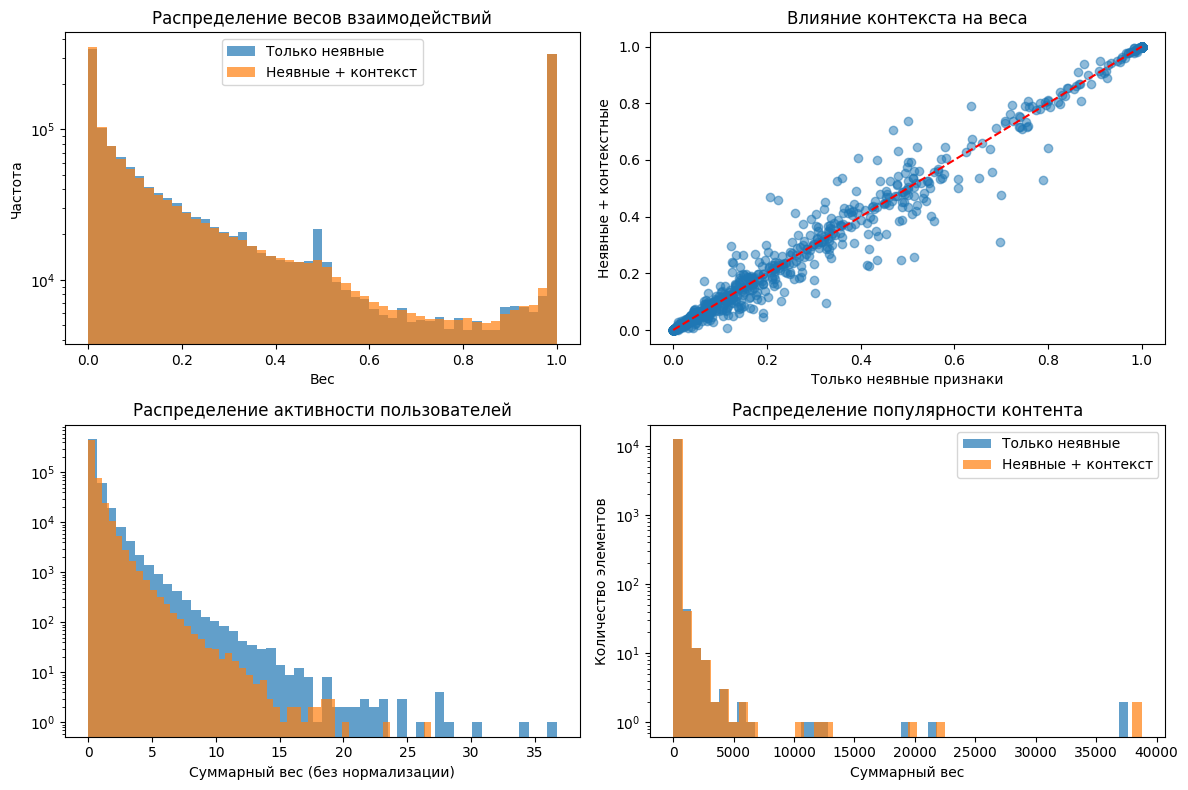

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 8.1 сравнение распределения весов
axes[0,0].hist(matrix_implicit.data, bins=50, alpha=0.7, label='Только неявные', log=True)
axes[0,0].hist(matrix_full_context.data, bins=50, alpha=0.7, label='Неявные + контекст', log=True)
axes[0,0].set_title('Распределение весов взаимодействий')
axes[0,0].set_xlabel('Вес')
axes[0,0].set_ylabel('Частота')
axes[0,0].legend()

# 8.2 влияние контекста на веса
sample_data = interactions_context.sample(1000, random_state=42)
axes[0,1].scatter(sample_data['implicit_normalized'], sample_data['full_context_normalized'], alpha=0.5)
axes[0,1].plot([0, sample_data['implicit_normalized'].max()], [0, sample_data['implicit_normalized'].max()], 'r--')
axes[0,1].set_title('Влияние контекста на веса')
axes[0,1].set_xlabel('Только неявные признаки')
axes[0,1].set_ylabel('Неявные + контекстные')

# 8.3 активность пользователей
user_activity_implicit = interactions_context.groupby('user_id')['implicit_combined'].sum()
user_activity_full = interactions_context.groupby('user_id')['final_weight'].sum()

axes[1,0].hist(user_activity_implicit, bins=50, alpha=0.7, label='Только неявные', log=True)
axes[1,0].hist(user_activity_full, bins=50, alpha=0.7, label='Неявные + контекст', log=True)
axes[1,0].set_title('Распределение активности пользователей')
axes[1,0].set_xlabel('Суммарный вес (без нормализации)')


# 8.4 популярность контента
item_popularity_implicit = np.array(matrix_implicit.sum(axis=0)).flatten()
item_popularity_full = np.array(matrix_full_context.sum(axis=0)).flatten()

axes[1,1].hist(item_popularity_implicit, bins=50, alpha=0.7, label='Только неявные', log=True)
axes[1,1].hist(item_popularity_full, bins=50, alpha=0.7, label='Неявные + контекст', log=True)
axes[1,1].set_title('Распределение популярности контента')
axes[1,1].set_xlabel('Суммарный вес')
axes[1,1].set_ylabel('Количество элементов')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 9. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ

In [ ]:
save_npz('implicit_interactions_matrix.npz', matrix_implicit)
save_npz('full_context_interactions_matrix.npz', matrix_full_context)

import pickle
with open('user_mapping.pkl', 'wb') as f:
    pickle.dump(user_map, f)
with open('item_mapping.pkl', 'wb') as f:
    pickle.dump(item_map, f)

print(" РЕЗУЛЬТАТЫ СОХРАНЕНЫ:")
print("   implicit_interactions_matrix.npz - матрица неявных взаимодействий")
print("   full_context_interactions_matrix.npz - матрица с контекстом")
print("   user_mapping.pkl, item_mapping.pkl - маппинги идентификаторов")

 РЕЗУЛЬТАТЫ СОХРАНЕНЫ:
   implicit_interactions_matrix.npz - матрица неявных взаимодействий
   full_context_interactions_matrix.npz - матрица с контекстом
   user_mapping.pkl, item_mapping.pkl - маппинги идентификаторов
